In [ ]:
!pip install torchaudio

     |████████████████████████████████| 1.9 MB 4.2 MB/s 


In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 4.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from __future__ import print_function
from __future__ import division
from typing import List

import os
import copy
import gc


import numpy as np
import pandas as pd
import timm
# import tqdm.notebook as tqdm

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision

from torch.optim.lr_scheduler import StepLR
import torchaudio

from matplotlib import pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

In [ ]:
# optimizer_ftfrom __future_ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# import tqdm
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.9.0+cu102
Torchvision Version:  0.10.0+cu102


In [ ]:
!tar -xf /content/drive/MyDrive/speech_commands_data.tar.gz

### штука, которую я делаю

In [ ]:
import pickle
with open('wav_idx (2).plk', 'rb') as f:
  dct=pickle.load(f)

FileNotFoundError: ignored

In [ ]:
class SpectogramDataset(Dataset):
    def __init__(self, annotation_file, noises_pathes, transform=None, target_transform=None):
        df = pd.read_csv(annotation_file)
        self._noises_pathes = noises_pathes
        try :
            dict_df = {w: i for i, w in enumerate(sorted(df['word'].unique()))}
            df['label'] = df['word'].apply(lambda x: dict_df[x])
            self._labels = df['label'].to_list()
        except Exception as e:
            self._labels = None
            self._names = df['name']
        self._pathes = df['path'].apply(lambda x: x.replace('\\', '/'))
        self._from_memory = {idx: torchaudio.load(self._pathes[idx]) for idx in range(self.__len__() )}
        if noises_pathes:
                  self._noises_from_memory = {idx: torchaudio.load(self._noises_pathes[idx]) for idx in range(len(self._noises_pathes))}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self._pathes)
    
    def _make_spec(self, audio):
        spec =  torchaudio.transforms.Spectrogram(n_fft = 160)(audio)
        return torch.nn.functional.interpolate(spec, size = 81)
    def _make_melspec(self, audio):
        melspec = torchaudio.transforms.MelSpectrogram(n_mels = 81)(audio)
        return melspec
    
    def _make_mfcc(self, audio):
        mfcc = torchaudio.transforms.MFCC(melkwargs={'n_mels': 80})(audio)
        return torch.nn.functional.interpolate(torch.swapdims(torch.nn.functional.interpolate(mfcc, size = 224), 1,2), 224)

    def __add_noise__(self, clean, noise, max_amp=1.0):
        noise_amp = np.random.rand() * max_amp
        max_start = noise.shape[1] - clean.shape[1]
        start = np.random.randint(0, max_start + 1)
        noise_part = noise[:, start:start+clean.shape[1]]
        noise_mult = clean.abs().max() / noise_part.abs().max() * noise_amp
        return (clean + noise_part * noise_mult) / (1 + noise_amp)

    def _create_spec(self, spec1, spec2, spec3):
        spec = torch.cat((spec1, spec2, spec3), 0)
        return spec
        #torch.nn.functional.interpolate(torch.swapdims(torch.nn.functional.interpolate(spec, size=224), 1,2),size=224)

    def __getitem__(self, idx):
        if self._noises_pathes:
                  n = np.random.choice(len(self._noises_pathes))
                  audio = self.__add_noise__(self._from_memory[idx][0], self._noises_from_memory[n][0], max_amp=1.0)
        else:
            audio = self._from_memory[idx][0]
        
        X = torch.zeros(( 1, 16000))
        
        diff = 16000 - audio.shape[1]
        start = diff // 2
        end = 16000 - diff + start
        X[:, start:end] = audio
        audio = X
        #audio = self._from_memory[idx]
        idd = self._pathes[idx].split('/')[-1]
        spec1 = self._make_spec(audio)
        spec2 = self._make_melspec(audio) 
        spec3 = self._make_melspec(audio)
        # spec3 = self._make_spec(audio, n_fft=224 * 2, 
        #                                   win_length=64*4, 
        #                                   hop_length=64)
        
        spec = self._create_spec(spec1, spec2, spec3)
        
        if self.transform:
            audio = self.transform(audio)
        if  self._labels:
            label = self._labels[idx]
            return spec, label, torch.tensor(dct[idd])
        return spec, self._names[idx], torch.tensor(dct[idd])


In [ ]:
class SpectogramDatasetVal(Dataset):
    def __init__(self, annotation_file, noises_pathes, transform=None, target_transform=None):
        df = pd.read_csv(annotation_file)
        self._noises_pathes = noises_pathes
        try :
            dict_df = {w: i for i, w in enumerate(sorted(df['word'].unique()))}
            df['label'] = df['word'].apply(lambda x: dict_df[x])
            self._labels = df['label'].to_list()
        except Exception as e:
            self._labels = None
            self._names = df['name']
        self._pathes = df['path'].apply(lambda x: x.replace('\\', '/'))
        # self._from_memory = {idx: torchaudio.load(self._pathes[idx]) for idx in range(self.__len__() )}
        if noises_pathes:
                  self._noises_from_memory = {idx: torchaudio.load(self._noises_pathes[idx]) for idx in range(len(self._noises_pathes))}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self._pathes)
    
    def _make_spec(self, audio):
        spec =  torchaudio.transforms.Spectrogram(n_fft = 160)(audio)
        return torch.nn.functional.interpolate(spec, size = 81)
    def _make_melspec(self, audio):
        melspec = torchaudio.transforms.MelSpectrogram(n_mels = 81)(audio)
        return melspec
    
    def _make_mfcc(self, audio):
        mfcc = torchaudio.transforms.MFCC(melkwargs={'n_mels': 80})(audio)
        return torch.nn.functional.interpolate(torch.swapdims(torch.nn.functional.interpolate(mfcc, size = 224), 1,2), 224)

    def __add_noise__(self, clean, noise, max_amp=1.0):
        noise_amp = np.random.rand() * max_amp
        max_start = noise.shape[1] - clean.shape[1]
        start = np.random.randint(0, max_start + 1)
        noise_part = noise[:, start:start+clean.shape[1]]
        noise_mult = clean.abs().max() / noise_part.abs().max() * noise_amp
        return (clean + noise_part * noise_mult) / (1 + noise_amp)

    def _create_spec(self, spec1, spec2, spec3):
        spec = torch.cat((spec1, spec2, spec3), 0)
        return spec
        #torch.nn.functional.interpolate(torch.swapdims(torch.nn.functional.interpolate(spec, size=224), 1,2),size=224)

    def __getitem__(self, idx):
        if self._noises_pathes:
                  n = np.random.choice(len(self._noises_pathes))
                  audio = self.__add_noise__(torchaudio.load(self._pathes[idx])[0], self._noises_from_memory[n][0], max_amp=1.0)
        else:
            audio = torchaudio.load(self._pathes[idx])[0]
        
        X = torch.zeros(( 1, 16000))
        
        diff = 16000 - audio.shape[1]
        start = diff // 2
        end = 16000 - diff + start
        X[:, start:end] = audio
        audio = X
        #audio = self._from_memory[idx]
        idd = self._pathes[idx].split('/')[-1]
        spec1 = self._make_spec(audio)
        spec2 = self._make_melspec(audio) 
        spec3 = self._make_melspec(audio)
        # spec3 = self._make_spec(audio, n_fft=224 * 2, 
        #                                   win_length=64*4, 
        #                                   hop_length=64)
        
        spec = self._create_spec(spec1, spec2, spec3)
        
        if self.transform:
            audio = self.transform(audio)
        if  self._labels:
            label = self._labels[idx]
            return spec, label, torch.tensor(dct[idd])
        return spec, self._names[idx], torch.tensor(dct[idd])


тут тыкаю в спектограммы


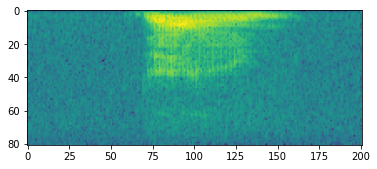

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spotter_denoiser_challenge/data.csv')['path'].apply(lambda x: x.replace('\\', '/'))
audio = torchaudio.load(os.path.join('/content', data[1]))
#plt.imshow(torchaudio.transforms.MelSpectrogram(n_mels = 81)(audio[0]).squeeze().log2())
wh = torchaudio.transforms.Spectrogram(n_fft = 160)(audio[0])
plt.imshow(wh.squeeze().log2())

In [ ]:
wh = torch.nn.functional.interpolate(wh,size = 81)
plt.imshow(wh.squeeze().log2())

NameError: ignored

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spotter_denoiser_challenge/data.csv')['path'].apply(lambda x: x.replace('\\', '/'))
audio = torchaudio.load(os.path.join('/content', data[1]))
#plt.imshow(torchaudio.transforms.MelSpectrogram(n_mels = 81)(audio[0]).squeeze().log2())
wh = torchaudio.transforms.MFCC(melkwargs={'n_mels': 80})(audio[0])
# wh = torch.nn.functional.interpolate(torch.swapdims(torch.nn.functional.interpolate(wh, size = 225), 1,2), 251)
#wh = torch.nn.functional.interpolate(torch.swapdims(torch.nn.functional.interpolate(wh, size=224), 1,2),size=224)
wh.size()

In [ ]:
wh = torchaudio.transforms.Spectrogram(n_fft=224 * 2, 
                                          win_length=64*2, 
                                          hop_length=64)(audio[0])
wh.size()

потыкала


In [ ]:
names = os.listdir('/content/noises')
noises_pathes = []
for name in names:
    noises_pathes.append(os.path.join('/content/noises', name)) 

In [ ]:
training_data = SpectogramDataset(annotation_file = '/content/drive/MyDrive/spotter_denoiser_challenge/train.csv', noises_pathes = noises_pathes)
test_data = SpectogramDataset(annotation_file = '/content/drive/MyDrive/spotter_denoiser_challenge/test.csv', noises_pathes = noises_pathes)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)#, shuffle=True)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
num_classes = 20
batch_size = 128
num_epochs = 3
feature_extract = True

In [ ]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    model_ft = timm.create_model('efficientnetv2_rw_m',pretrained=True)
    # model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier = nn.Sequential(nn.Linear(2152, 512),nn.BatchNorm1d(512), nn.Dropout(0.2), nn.ReLU(), nn.Linear(512,128),nn.BatchNorm1d(128), nn.ReLU(), nn.Linear(128,20), nn.Softmax(dim = 1))
    input_size = 224

    return model_ft, input_size

feature_extracting = True
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnetv2_rw_m_agc-3d90cb1e.pth" to /root/.cache/torch/hub/checkpoints/efficientnetv2_rw_m_agc-3d90cb1e.pth


In [ ]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/spotter_denoiser_challenge/withsoftmax81.plk')) 

RuntimeError: ignored

# Новый раздел

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    outputs_dct={}
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, idd in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs_dct[idd]=outputs.detach().cpu()
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), '/content/drive/MyDrive/spotter_denoiser_challenge/withsoftmax_sec20.plk')
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history,outputs_dct

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#первый раз, зафиксируем

In [ ]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.008, momentum=0.9)
scheduler = StepLR(optimizer_ft, step_size = 1, gamma = 0.8)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.5.weight
	 classifier.5.bias
	 classifier.7.weight
	 classifier.7.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {'train': train_dataloader, 'val': test_dataloader}
model_name = 'resnet'

In [ ]:
model_ft, hist, outputs_dct = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

optimizer_ftoptimizer_ftxssfgygggggggggggjkmbmbnmbвторой раз, тут размораживаем оставшиеся

In [ ]:
batch_size = 128
num_epochs = 20
feature_extract = False

for param in model_ft.parameters():
    param.requires_grad = True

In [ ]:
def fintest_func(fintest_dataloader, model):
    model.eval()
    ret_dict = {'names': [], 'logits': []}
    for inputs, names, idd in tqdm(fintest_dataloader):
          inputs = inputs.to(device)
          with torch.set_grad_enabled(False):
            outputs = model(inputs)
          ret_dict['names'].extend(names)
          ret_dict['logits'].extend(outputs)
    return ret_dict          

In [ ]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer_ft, step_size = 1, gamma = 0.8)

Params to learn:
	 conv_stem.weight
	 bn1.weight
	 bn1.bias
	 blocks.0.0.conv_exp.weight
	 blocks.0.0.bn1.weight
	 blocks.0.0.bn1.bias
	 blocks.0.0.conv_pwl.weight
	 blocks.0.0.bn2.weight
	 blocks.0.0.bn2.bias
	 blocks.0.1.conv_exp.weight
	 blocks.0.1.bn1.weight
	 blocks.0.1.bn1.bias
	 blocks.0.1.conv_pwl.weight
	 blocks.0.1.bn2.weight
	 blocks.0.1.bn2.bias
	 blocks.0.2.conv_exp.weight
	 blocks.0.2.bn1.weight
	 blocks.0.2.bn1.bias
	 blocks.0.2.conv_pwl.weight
	 blocks.0.2.bn2.weight
	 blocks.0.2.bn2.bias
	 blocks.1.0.conv_exp.weight
	 blocks.1.0.bn1.weight
	 blocks.1.0.bn1.bias
	 blocks.1.0.conv_pwl.weight
	 blocks.1.0.bn2.weight
	 blocks.1.0.bn2.bias
	 blocks.1.1.conv_exp.weight
	 blocks.1.1.bn1.weight
	 blocks.1.1.bn1.bias
	 blocks.1.1.conv_pwl.weight
	 blocks.1.1.bn2.weight
	 blocks.1.1.bn2.bias
	 blocks.1.2.conv_exp.weight
	 blocks.1.2.bn1.weight
	 blocks.1.2.bn1.bias
	 blocks.1.2.conv_pwl.weight
	 blocks.1.2.bn2.weight
	 blocks.1.2.bn2.bias
	 blocks.1.3.conv_exp.weight
	 blocks.1.

In [ ]:
for g in optimizer_ft.param_groups:
    g['lr'] = 0.008

In [ ]:
model_ft, hist, outputs_dct = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/19
----------



train Loss: 2.8704 Acc: 0.2122



val Loss: 2.7914 Acc: 0.2899

Epoch 1/19
----------



train Loss: 2.7546 Acc: 0.3249



val Loss: 2.7033 Acc: 0.3838

Epoch 2/19
----------



train Loss: 2.6711 Acc: 0.4110



val Loss: 2.6310 Acc: 0.4514

Epoch 3/19
----------



train Loss: 2.5710 Acc: 0.5159



val Loss: 2.5267 Acc: 0.5558

Epoch 4/19
----------



train Loss: 2.5097 Acc: 0.5721



val Loss: 2.4806 Acc: 0.6020

Epoch 5/19
----------



train Loss: 2.4495 Acc: 0.6357



val Loss: 2.4137 Acc: 0.6703

Epoch 6/19
----------



train Loss: 2.3981 Acc: 0.6889



val Loss: 2.3848 Acc: 0.6990

Epoch 7/19
----------



train Loss: 2.3574 Acc: 0.7244



val Loss: 2.3768 Acc: 0.7049

Epoch 8/19
----------



train Loss: 2.3389 Acc: 0.7428



val Loss: 2.3449 Acc: 0.7357

Epoch 9/19
----------



train Loss: 2.3230 Acc: 0.7584



val Loss: 2.3064 Acc: 0.7761

Epoch 10/19
----------



train Loss: 2.2955 Acc: 0.7864



val Loss: 2.2930 Acc: 0.7869

Epoch 11/19
----------



train Loss: 2.2835 Acc: 0.7981



val Loss: 2.2911 Acc: 0.7891

Epoch 12/19
----------



train Loss: 2.2781 Acc: 0.8023



val Loss: 2.2819 Acc: 0.7982

Epoch 13/19
----------



train Loss: 2.2684 Acc: 0.8114



val Loss: 2.3130 Acc: 0.7659

Epoch 14/19
----------



train Loss: 2.2616 Acc: 0.8184



val Loss: 2.2954 Acc: 0.7836

Epoch 15/19
----------



train Loss: 2.2578 Acc: 0.8214



val Loss: 2.2638 Acc: 0.8145

Epoch 16/19
----------



train Loss: 2.2539 Acc: 0.8256



val Loss: 2.2869 Acc: 0.7919

Epoch 17/19
----------



train Loss: 2.2498 Acc: 0.8297



val Loss: 2.2646 Acc: 0.8144

Epoch 18/19
----------



train Loss: 2.2471 Acc: 0.8323



val Loss: 2.2768 Acc: 0.8017

Epoch 19/19
----------



train Loss: 2.2426 Acc: 0.8368



val Loss: 2.3114 Acc: 0.7673

Training complete in 152m 27s
Best val Acc: 0.814549


In [ ]:
#model_ft, hist, outputs_dct = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_inception=(model_name=="inception"))
#!!!!!!!!!!!!!!!!!!!!out_logits{}
fintest_data = SpectogramDatasetVal(annotation_file = '/content/drive/MyDrive/spotter_denoiser_challenge/fin_test.csv', noises_pathes = None)
fintest_dataloader = DataLoader(fintest_data, batch_size = 64, shuffle = False) 
dct_outputs = fintest_func(fintest_dataloader, model_ft)
with open('/content/drive/MyDrive/spotter_denoiser_challenge/out_logits_withsoftmax.plk', 'wb') as f:
   pickle.dump(dct_outputs,f)